# Clean genetic algorithm

In [2]:
import random
from matplotlib import pyplot as plt
from pprint import pprint

class Genetic_solver:
    def __init__(self):
        # genetic parameters and data
        self.best_for_gen_x = []
        self.population = []
        self.generations = []
        self.M = 20 # Population size
        self.N = 15 # Generations count
        self.p_c = 1.0
        self.p_m = 0.01
        self.k = 3
        self.l = 20
        # solution parameters
        self.a = -10
        self.b = 10
        self.inputs = 1
        self.objective = lambda x: x**2
    def set_objective(self, obj_func, inputs):
        self.objective = obj_func
        self.inputs = inputs
    def set_search_space(self, a, b):
        self.a = a
        self.b = b
    def set_crossover_probability(self, p_c):
        self.p_c = p_c
    def set_mutation_probability(self, p_m):
        self.p_m = p_m
    def set_population_size(self, M):
        self.M = M
    def set_generations_count(self, N):
        self.N = N
    def set_tournament_size(self, k):
        self.k = k
    def set_chromosome_length(self, l):
        self.l = l
    # Sometimes we have more than one input to our objective function,
    # here we split the chromosome into the corresponding solutions:
    def split_chromosome(self, chromosome):
        solutions = ()
        step = self.l // self.inputs
        return tuple(chromosome[index:(index+step)]
                for index in range(0, self.l, step)
               )
    # gets precision value for computing the decoding of the solution
    def get_precision(self, solution):
        return (self.b-self.a)/(2**len(solution) - 1)
    # encoding and decoding solutions:
    def decode_genes(self, solution):
        precision = self.get_precision(solution)
        return sum([self.b*2**i 
                        for i, self.b in enumerate(reversed(solution))
            ]) * precision + self.a
    def gen_random_solution(self):
        return [1 if random.random() >= 0.5 else 0
                for _ in range(self.l)]
    # evaluate objective based on a solution's chromosome and inputs specs
    def evaluate_objective(self, chromosome):
        chroms = self.split_chromosome(chromosome)
        values = [self.decode_genes(chrom) for chrom in chroms]
        return self.objective(*values)
    # crea poblacion inicial
    def create_random_population(self):
        return [gen_random_solution(self.l) for _ in range(self.N)]
    # crossover two solutions randomly
    def crossover_random(self, p_a, p_b):
        indexes = {i for i in range(self.l)}
        # select which genes will come from which parent
        p_a_genes = sorted(list(random.sample(indexes, self.l//2)))
        p_b_genes = sorted(list(indexes - set(p_a_genes)))
        child = []
        for i in indexes:
            child.append(p_a[i] if i in p_a_genes else p_b[i])
        return child
    # select two points and cross parents info at those points
    # p_c means probability of crossover
    def crossover_two_points(self, p_a, p_b):
        if self.p_c >= random.random():
            indexes = {i for i in range(self.l)}
            # select which genes will come from which parent
            two_points = sorted(random.sample(indexes, 2))
            # print(f'two points: {two_points}')
            # extract segments from parent a
            first_seg_a = p_a[0:two_points[0]]
            mid_seg_a = p_a[two_points[0]:two_points[1]]
            last_seg_a = p_a[two_points[1]:]
            # extract segments from parent b
            first_seg_b = p_b[0:two_points[0]]
            mid_seg_b = p_b[two_points[0]:two_points[1]]
            last_seg_b = p_b[two_points[1]:]
            # create child # 1
            child = first_seg_a + mid_seg_b + last_seg_a
            child_2 = first_seg_b + mid_seg_a + last_seg_b
            return child, child_2
        else:
            return p_a, p_b # no crossover, same childs as parents
    # abnormal children
    def mutate_child(self, child):
        return [gen if random.random() > self.p_m else (1 - gen)
                    for gen in child]
    # select an individual from the population,
    # picking the best of k individuals from a tournament
    def selection_tournament(self, current_population):
        # Father tournament
        contestants = random.sample(list(enumerate(current_population)), self.k)
        i, father = min(contestants, 
                     key= lambda contestant: self.evaluate_objective(contestant[1]))
        return i, father
    # para mostrar los valores objetivo (y) vs los # de generacion (x) en una grafica chida
    def display_generations(self):
        # crea lista de individuos, asignandoles su # de generacion
        genealogy = [
            (i, self.evaluate_objective(specimen))
            for i, gen in enumerate(self.generations)
                for specimen in gen]
        x, y = zip(*genealogy)
        plt.scatter(x, y)
        plt.show()
    # run algorithm
    def solve(self):
        # Create initial population
        self.population = [self.gen_random_solution() for _ in range(self.M)]
        # track del mejor por generacion
        self.best_for_gen_x.append(min(self.population, 
                                       key=lambda chrom: 
                                           self.evaluate_objective(chrom)))
        print(f'best for first generation is: {self.best_for_gen_x[-1]}')
        print(f'value = {self.evaluate_objective(self.best_for_gen_x[-1])}')
        # itera algoritmo por cada una de las generaciones
        current_population = self.population
        self.generations = []
        for n in range(self.N):
            print(f'Generation #{n+1}:')
            # evalúa a esta generacion
            self.generations.append(current_population)
            # crea siguiente generacion
            children = []
            for m in range(self.M//2):
                i, fath = self.selection_tournament(current_population)
                current_population.pop(i)
                j, moth = self.selection_tournament(current_population)
                current_population.insert(i, fath)
                ch_1, ch_2 = self.crossover_two_points(fath, moth)
                ch_1 = self.mutate_child(ch_1)
                ch_2 = self.mutate_child(ch_2)
                children.extend([ch_1, ch_2])
                # agrega el mejor hijo a la lista de mejores:
                best_child = min(children, key=lambda chrom: self.evaluate_objective(chrom))
                self.best_for_gen_x.append(best_child)
            current_population = children # avanza de generacion y repite
        print(f'best for last generation is: {self.best_for_gen_x[-1]}')
        print(f'value = {self.evaluate_objective(self.best_for_gen_x[-1])}')
        solution_chroms = self.split_chromosome(self.best_for_gen_x[-1])
        solution_values = [self.decode_genes(chrom) for chrom in solution_chroms]
        print(f'solution values: {solution_values}')

# Genetic algorithm runner example:

best for first generation is: [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0]
value = 1.642803378444145
Generation #1:
Generation #2:
Generation #3:
Generation #4:
Generation #5:
Generation #6:
Generation #7:
Generation #8:
Generation #9:
Generation #10:
Generation #11:
Generation #12:
Generation #13:
Generation #14:
Generation #15:
Generation #16:
Generation #17:
Generation #18:
Generation #19:
Generation #20:
Generation #21:
Generation #22:
Generation #23:
Generation #24:
Generation #25:
Generation #26:
Generation #27:
Generation #28:
Generation #29:
Generation #30:
Generation #31:
Generation #32:
Generation #33:
Generation #34:
Generation #35:
Generation #36:
Generation #37:
Generation #38:
Generation #39:
Generation #40:
best for last generation is: [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 

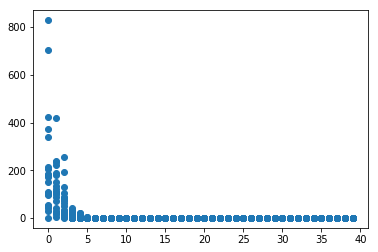

In [5]:
#OBJECTIVE FUNCTIONS
def himmelblau(x, y):
    return ((x**2)+y-11)**2+(x+(y**2)-7)**2
def obj_fun_3(x):
    return (x/10)**5-5*(x/10)**4+5*(x/10)**3+5*(x/10)**2-6*(x/10)-1
        
solver = Genetic_solver()
# genetic params
solver.set_crossover_probability(0.95)
solver.set_mutation_probability(0.00)
solver.set_population_size(20)
solver.set_generations_count(40)
solver.set_tournament_size(3)
solver.set_chromosome_length(60)
# solution params
solver.set_objective(himmelblau, 2)
solver.set_search_space(-6, 6)
# solve the fucker
solver.solve()
solver.display_generations()